# Proxy Target Variable Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')


In [2]:
# -------------------------------------------------------------------
# 1. LOAD RAW DATA DIRECTLY
# -------------------------------------------------------------------
print("📊 LOADING RAW DATA FOR RFM ANALYSIS")
print("=" * 60)

raw_path = "/Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/raw/data.csv"

try:
    df_raw = pd.read_csv(raw_path)
    print(f"✅ Loaded raw data: {df_raw.shape}")
    print(f"Columns: {df_raw.columns.tolist()}")
    
    # Check required columns
    required_cols = ['CustomerId', 'Amount', 'TransactionStartTime']
    missing_cols = [col for col in required_cols if col not in df_raw.columns]
    
    if missing_cols:
        print(f"❌ Missing required columns: {missing_cols}")
        print("Please check your data columns.")
        # Look for similar column names
        print("\nLooking for similar column names...")
        for required in required_cols:
            similar = [col for col in df_raw.columns if required.lower() in col.lower()]
            if similar:
                print(f"  For '{required}', found: {similar}")
    else:
        print("✅ All required columns present!")
        
except FileNotFoundError:
    print(f"❌ File not found: {raw_path}")
    print("Please check the file path.")


📊 LOADING RAW DATA FOR RFM ANALYSIS
✅ Loaded raw data: (95662, 16)
Columns: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult']
✅ All required columns present!


In [3]:
# -------------------------------------------------------------------
# 2. EXPLORE THE DATA
# -------------------------------------------------------------------
print("\n🔍 EXPLORING DATA")
print("=" * 60)

print(f"Total transactions: {len(df_raw):,}")
print(f"Unique customers: {df_raw['CustomerId'].nunique():,}")
print(f"Date range: {df_raw['TransactionStartTime'].min()} to {df_raw['TransactionStartTime'].max()}")
print(f"\nAmount statistics:")
print(f"  Min: ${df_raw['Amount'].min():.2f}")
print(f"  Max: ${df_raw['Amount'].max():.2f}")
print(f"  Mean: ${df_raw['Amount'].mean():.2f}")
print(f"  Median: ${df_raw['Amount'].median():.2f}")

# Show sample of data
print(f"\n📋 Sample of raw data (first 3 rows):")
print(df_raw[['CustomerId', 'Amount', 'TransactionStartTime']].head(3))



🔍 EXPLORING DATA
Total transactions: 95,662
Unique customers: 3,742
Date range: 2018-11-15T02:18:49Z to 2019-02-13T10:01:28Z

Amount statistics:
  Min: $-1000000.00
  Max: $9880000.00
  Mean: $6717.85
  Median: $1000.00

📋 Sample of raw data (first 3 rows):
        CustomerId  Amount  TransactionStartTime
0  CustomerId_4406  1000.0  2018-11-15T02:18:49Z
1  CustomerId_4406   -20.0  2018-11-15T02:19:08Z
2  CustomerId_4683   500.0  2018-11-15T02:44:21Z


In [4]:
# -------------------------------------------------------------------
# 3. CALCULATE RFM METRICS
# -------------------------------------------------------------------
print("\n🔢 CALCULATING RFM METRICS")
print("=" * 60)

def calculate_rfm_advanced(df, customer_col='CustomerId', amount_col='Amount', date_col='TransactionStartTime'):
    """
    Calculate advanced RFM metrics with additional features.
    """
    df = df.copy()
    
    # Convert date column to datetime
    print(f"Converting {date_col} to datetime...")
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Remove rows with invalid dates
    invalid_dates = df[date_col].isnull().sum()
    if invalid_dates > 0:
        print(f"Removing {invalid_dates} rows with invalid dates")
        df = df.dropna(subset=[date_col])
    
    # Define snapshot date (most recent transaction date + 1 day)
    snapshot_date = df[date_col].max() + pd.Timedelta(days=1)
    print(f"Snapshot date: {snapshot_date.date()}")
    
    print(f"Calculating RFM for {df[customer_col].nunique():,} customers...")
    
    # Basic RFM calculation
    rfm = df.groupby(customer_col).agg({
        date_col: lambda x: (snapshot_date - x.max()).days,  # Recency
        customer_col: 'count',  # Frequency
        amount_col: 'sum'  # Monetary
    }).rename(columns={
        date_col: 'Recency',
        customer_col: 'Frequency',
        amount_col: 'Monetary'
    })
    
    # Additional metrics
    rfm['Avg_Transaction_Value'] = rfm['Monetary'] / rfm['Frequency']
    
    # Calculate transaction days span
    date_stats = df.groupby(customer_col)[date_col].agg(['min', 'max']).reset_index()
    date_stats['Transaction_Days'] = (date_stats['max'] - date_stats['min']).dt.days
    date_stats['Transaction_Days'] = date_stats['Transaction_Days'].replace(0, 1)  # Avoid division by zero
    
    rfm = rfm.reset_index().merge(date_stats[[customer_col, 'Transaction_Days']], on=customer_col)
    
    # Additional derived features
    rfm['Transaction_Frequency'] = rfm['Frequency'] / rfm['Transaction_Days']  # Transactions per day
    rfm['Monetary_Per_Day'] = rfm['Monetary'] / rfm['Transaction_Days']  # Spending per day
    
    # Calculate customer tenure (days since first transaction)
    rfm['Tenure'] = (snapshot_date - date_stats['min']).dt.days
    
    print("✅ RFM calculation complete!")
    return rfm

# Calculate RFM
rfm_df = calculate_rfm_advanced(df_raw)
print(f"\n📋 RFM Data Sample (first 5 customers):")
print(rfm_df.head())

print(f"\n📊 RFM Statistics:")
print(rfm_df[['Recency', 'Frequency', 'Monetary', 'Transaction_Days', 'Tenure']].describe())


🔢 CALCULATING RFM METRICS
Converting TransactionStartTime to datetime...
Snapshot date: 2019-02-14
Calculating RFM for 3,742 customers...
✅ RFM calculation complete!

📋 RFM Data Sample (first 5 customers):
        CustomerId  Recency  Frequency  Monetary  Avg_Transaction_Value  \
0     CustomerId_1       84          1  -10000.0          -10000.000000   
1    CustomerId_10       84          1  -10000.0          -10000.000000   
2  CustomerId_1001       90          5   20000.0            4000.000000   
3  CustomerId_1002       26         11    4225.0             384.090909   
4  CustomerId_1003       12          6   20000.0            3333.333333   

   Transaction_Days  Transaction_Frequency  Monetary_Per_Day  Tenure  
0                 1               1.000000     -10000.000000      84  
1                 1               1.000000     -10000.000000      84  
2                 1               5.000000      20000.000000      90  
3                63               0.174603         67.0634


📈 ANALYZING RFM DISTRIBUTIONS
💾 RFM distributions plot saved


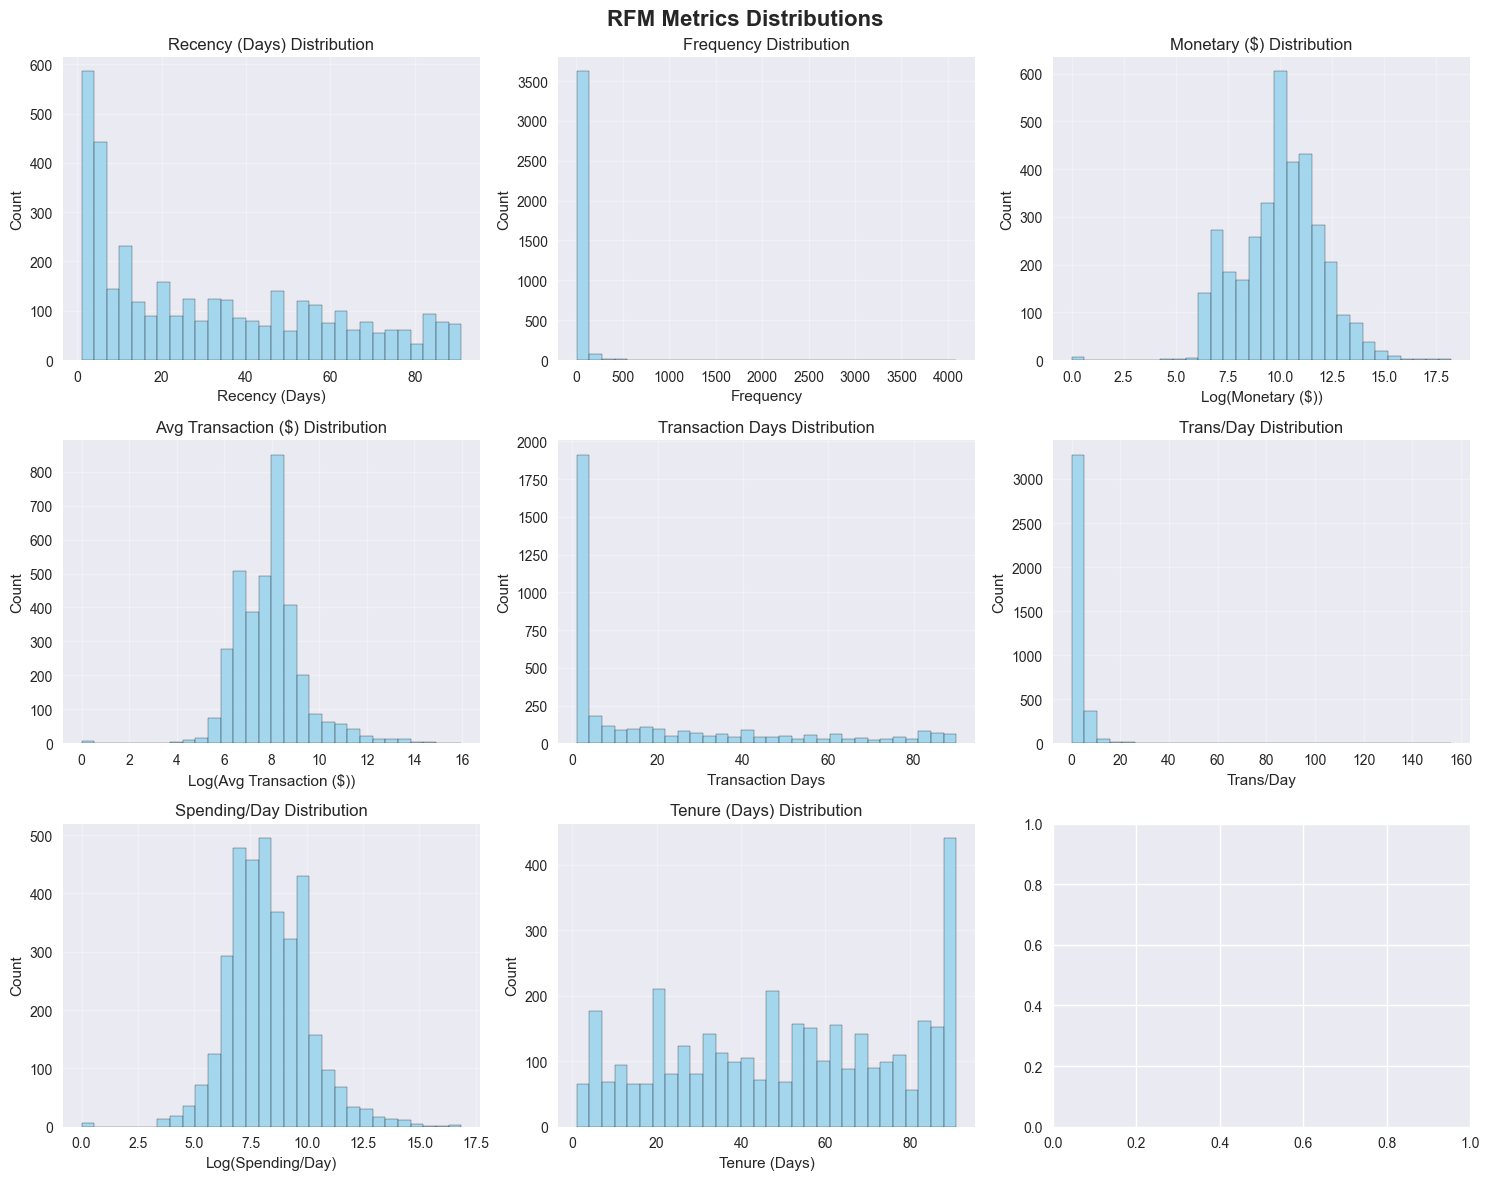

In [5]:
# -------------------------------------------------------------------
# 4. ANALYZE RFM DISTRIBUTIONS
# -------------------------------------------------------------------
print("\n📈 ANALYZING RFM DISTRIBUTIONS")
print("=" * 60)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Plot distributions
metrics = ['Recency', 'Frequency', 'Monetary', 'Avg_Transaction_Value', 'Transaction_Days', 'Transaction_Frequency', 'Monetary_Per_Day', 'Tenure']
titles = ['Recency (Days)', 'Frequency', 'Monetary ($)', 'Avg Transaction ($)', 'Transaction Days', 'Trans/Day', 'Spending/Day', 'Tenure (Days)']

for idx, (metric, title) in enumerate(zip(metrics[:8], titles[:8])):
    row = idx // 3
    col = idx % 3
    
    if metric in ['Monetary', 'Avg_Transaction_Value', 'Monetary_Per_Day']:
        # Use log scale for monetary metrics
        data = np.log1p(rfm_df[metric])
        axes[row, col].hist(data, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        axes[row, col].set_xlabel(f'Log({title})')
    else:
        axes[row, col].hist(rfm_df[metric], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        axes[row, col].set_xlabel(title)
    
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_title(f'{title} Distribution')
    axes[row, col].grid(True, alpha=0.3)

plt.suptitle('RFM Metrics Distributions', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save figure
output_dir = "/Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/processed/"
import os
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}rfm_distributions_detailed.png", dpi=300, bbox_inches='tight')
print(f"💾 RFM distributions plot saved")
plt.show()

In [6]:
# -------------------------------------------------------------------
# 5. PREPROCESS FOR CLUSTERING
# -------------------------------------------------------------------
print("\n🔧 PREPROCESSING FOR CLUSTERING")
print("=" * 60)

# Select features for clustering (core RFM + derived features)
clustering_features = ['Recency', 'Frequency', 'Monetary', 'Transaction_Days', 'Transaction_Frequency']
rfm_cluster = rfm_df[clustering_features].copy()

print("Selected features for clustering:", clustering_features)
print(f"\nOriginal statistics:")
print(rfm_cluster.describe())

# Handle outliers using robust scaling (less sensitive to outliers)
def robust_scale_features(df):
    """Scale features using median and IQR (more robust to outliers)."""
    df_scaled = df.copy()
    for col in df.columns:
        median = df[col].median()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        if iqr > 0:  # Avoid division by zero
            df_scaled[col] = (df[col] - median) / iqr
        else:
            df_scaled[col] = (df[col] - median) / (df[col].std() + 1e-10)
    return df_scaled

# Apply robust scaling
rfm_scaled = robust_scale_features(rfm_cluster)

print(f"\n✅ Features scaled for clustering")
print("Scaled statistics:")
print(rfm_scaled.describe())


🔧 PREPROCESSING FOR CLUSTERING
Selected features for clustering: ['Recency', 'Frequency', 'Monetary', 'Transaction_Days', 'Transaction_Frequency']

Original statistics:
           Recency    Frequency      Monetary  Transaction_Days  \
count  3742.000000  3742.000000  3.742000e+03       3742.000000   
mean     31.461251    25.564404  1.717377e+05         19.409407   
std      27.118932    96.929602  2.717305e+06         26.557573   
min       1.000000     1.000000 -1.049000e+08          1.000000   
25%       6.000000     2.000000  4.077438e+03          1.000000   
50%      25.000000     7.000000  2.000000e+04          3.000000   
75%      54.000000    20.000000  7.996775e+04         32.000000   
max      91.000000  4091.000000  8.345124e+07         90.000000   

       Transaction_Frequency  
count            3742.000000  
mean                2.728233  
std                 5.665802  
min                 0.032258  
25%                 0.809524  
50%                 1.000000  
75%      


🔍 DETERMINING OPTIMAL NUMBER OF CLUSTERS
Calculating cluster metrics...
  k=2: WCSS = 2714020.82
  k=3: WCSS = 747152.43
  k=4: WCSS = 343970.46
  k=5: WCSS = 253518.66
  k=6: WCSS = 164793.93
  k=7: WCSS = 125473.00
  k=8: WCSS = 106124.64
  k=9: WCSS = 85460.30
  k=10: WCSS = 73442.46
💾 Elbow analysis saved


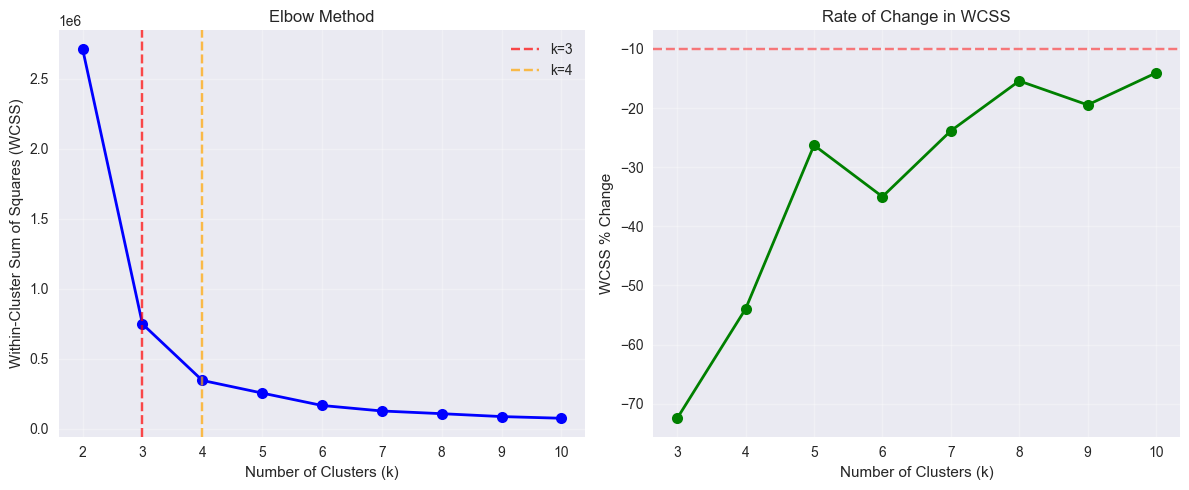


✅ Based on task requirements, using k=3 clusters


In [7]:
# -------------------------------------------------------------------
# 6. DETERMINE OPTIMAL CLUSTERS
# -------------------------------------------------------------------
print("\n🔍 DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("=" * 60)

# Calculate WCSS for different k values
wcss = []
silhouette_scores = []
k_range = range(2, 11)

print("Calculating cluster metrics...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    print(f"  k={k}: WCSS = {kmeans.inertia_:.2f}")

# Plot elbow curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3')
plt.axvline(x=4, color='orange', linestyle='--', alpha=0.7, label='k=4')
plt.legend()

# Calculate percentage change in WCSS
wcss_pct_change = np.diff(wcss) / wcss[:-1] * 100
plt.subplot(1, 2, 2)
plt.plot(range(3, 11), wcss_pct_change, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS % Change')
plt.title('Rate of Change in WCSS')
plt.grid(True, alpha=0.3)
plt.axhline(y=-10, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(f"{output_dir}elbow_analysis.png", dpi=300, bbox_inches='tight')
print(f"💾 Elbow analysis saved")
plt.show()

print(f"\n✅ Based on task requirements, using k=3 clusters")


🎯 PERFORMING K-MEANS CLUSTERING (k=3)
✅ Clustering completed!

📊 Cluster Distribution:
  Cluster 0: 3736 customers (99.8%)
  Cluster 1: 5 customers (0.1%)
  Cluster 2: 1 customers (0.0%)

📊 ANALYZING CLUSTER CHARACTERISTICS
Detailed Cluster Statistics:
        Recency                       Frequency                                 Monetary                                                     Transaction_Days        Transaction_Frequency        Tenure        CustomerId
           mean median    std min max      mean  median    std   min   max          mean       median          std          min          max             mean median                  mean median   mean median      count
Cluster                                                                                                                                                                                                                   
0         31.47   25.0  27.12   1  91     24.38     7.0  70.50     1  2085  1.322412e+05 

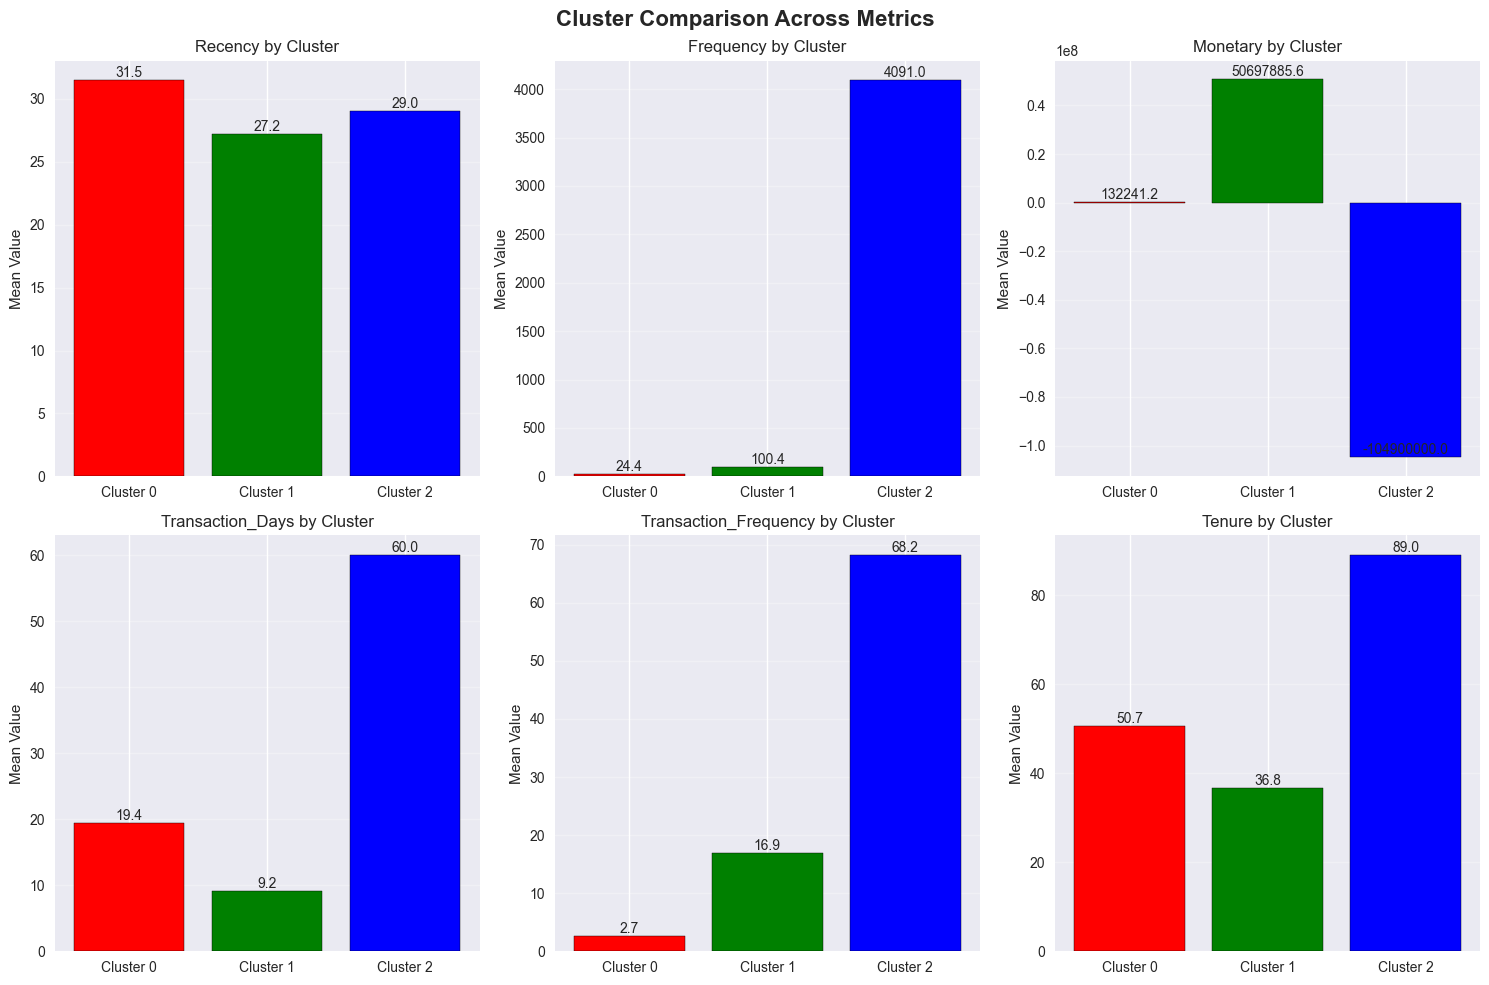

In [8]:
# -------------------------------------------------------------------
# 7. PERFORM K-MEANS CLUSTERING (k=3)
# -------------------------------------------------------------------
print("\n🎯 PERFORMING K-MEANS CLUSTERING (k=3)")
print("=" * 60)

# Apply K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("✅ Clustering completed!")
print(f"\n📊 Cluster Distribution:")
cluster_sizes = rfm_df['Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    percentage = size / len(rfm_df) * 100
    print(f"  Cluster {cluster}: {size} customers ({percentage:.1f}%)")

# -------------------------------------------------------------------
# 8. ANALYZE CLUSTERS IN DETAIL
# -------------------------------------------------------------------
print("\n📊 ANALYZING CLUSTER CHARACTERISTICS")
print("=" * 60)

# Calculate detailed cluster statistics
cluster_stats = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std', 'min', 'max'],
    'Frequency': ['mean', 'median', 'std', 'min', 'max'],
    'Monetary': ['mean', 'median', 'std', 'min', 'max'],
    'Transaction_Days': ['mean', 'median'],
    'Transaction_Frequency': ['mean', 'median'],
    'Tenure': ['mean', 'median'],
    'CustomerId': 'count'
}).round(2)

print("Detailed Cluster Statistics:")
print(cluster_stats.to_string())

# Create visual comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics_to_plot = ['Recency', 'Frequency', 'Monetary', 'Transaction_Days', 'Transaction_Frequency', 'Tenure']
colors = ['red', 'green', 'blue']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    
    cluster_means = []
    for cluster in sorted(rfm_df['Cluster'].unique()):
        cluster_data = rfm_df[rfm_df['Cluster'] == cluster]
        cluster_means.append(cluster_data[metric].mean())
    
    bars = axes[row, col].bar(range(len(cluster_means)), cluster_means, color=colors, edgecolor='black')
    axes[row, col].set_xticks(range(len(cluster_means)))
    axes[row, col].set_xticklabels([f'Cluster {i}' for i in range(len(cluster_means))])
    axes[row, col].set_title(f'{metric} by Cluster')
    axes[row, col].set_ylabel('Mean Value')
    axes[row, col].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, value in zip(bars, cluster_means):
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                           f'{value:.1f}', ha='center', va='bottom')

plt.suptitle('Cluster Comparison Across Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{output_dir}cluster_comparison.png", dpi=300, bbox_inches='tight')
print(f"💾 Cluster comparison saved")
plt.show()

In [9]:
# -------------------------------------------------------------------
# 9. IDENTIFY HIGH-RISK CLUSTER
# -------------------------------------------------------------------
print("\n🎯 IDENTIFYING HIGH-RISK CLUSTER")
print("=" * 60)

# Define risk scoring function
def calculate_risk_score(cluster_data, overall_data):
    """Calculate comprehensive risk score for a cluster."""
    
    # Weights for different risk factors
    weights = {
        'Recency': 0.4,  # High recency = high risk (inactive)
        'Frequency': 0.3,  # Low frequency = high risk
        'Monetary': 0.2,  # Low monetary = high risk
        'Transaction_Frequency': 0.1  # Low transaction frequency = high risk
    }
    
    # Calculate normalized scores (higher = more risky)
    scores = {}
    
    # Recency: higher is riskier (more days since last transaction)
    scores['Recency'] = cluster_data['Recency'].mean() / overall_data['Recency'].mean()
    
    # Frequency: lower is riskier (inverse relationship)
    scores['Frequency'] = overall_data['Frequency'].mean() / cluster_data['Frequency'].mean()
    
    # Monetary: lower is riskier (inverse relationship)
    scores['Monetary'] = overall_data['Monetary'].mean() / cluster_data['Monetary'].mean()
    
    # Transaction Frequency: lower is riskier (inverse relationship)
    scores['Transaction_Frequency'] = overall_data['Transaction_Frequency'].mean() / cluster_data['Transaction_Frequency'].mean()
    
    # Calculate weighted risk score
    risk_score = sum(scores[metric] * weights[metric] for metric in weights)
    
    return risk_score, scores

# Calculate risk scores for each cluster
cluster_analysis = []

for cluster in sorted(rfm_df['Cluster'].unique()):
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster]
    
    risk_score, component_scores = calculate_risk_score(cluster_data, rfm_df)
    
    analysis = {
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Risk_Score': risk_score,
        'Avg_Recency': cluster_data['Recency'].mean(),
        'Avg_Frequency': cluster_data['Frequency'].mean(),
        'Avg_Monetary': cluster_data['Monetary'].mean(),
        'Avg_Transaction_Frequency': cluster_data['Transaction_Frequency'].mean()
    }
    
    # Add component scores
    analysis.update({f'Score_{k}': v for k, v in component_scores.items()})
    
    cluster_analysis.append(analysis)

# Create analysis DataFrame
analysis_df = pd.DataFrame(cluster_analysis).sort_values('Risk_Score', ascending=False)
analysis_df['Risk_Rank'] = range(1, len(analysis_df) + 1)

# Add descriptions
for i, row in analysis_df.iterrows():
    if row['Risk_Rank'] == 1:
        analysis_df.at[i, 'Description'] = 'HIGH RISK: Inactive, low engagement'
    elif row['Risk_Rank'] == 2:
        analysis_df.at[i, 'Description'] = 'MEDIUM RISK: Moderate engagement'
    else:
        analysis_df.at[i, 'Description'] = 'LOW RISK: Active, high value'

print("📊 Detailed Cluster Risk Analysis:")
print(analysis_df.to_string())

# Identify high-risk cluster
high_risk_cluster = analysis_df.loc[analysis_df['Risk_Rank'] == 1, 'Cluster'].values[0]
high_risk_data = rfm_df[rfm_df['Cluster'] == high_risk_cluster]

print(f"\n✅ IDENTIFIED: Cluster {high_risk_cluster} as HIGH-RISK")
print(f"\n🔍 HIGH-RISK PROFILE:")
print(f"   • Customers: {len(high_risk_data):,} ({len(high_risk_data)/len(rfm_df)*100:.1f}%)")
print(f"   • Avg Recency: {high_risk_data['Recency'].mean():.1f} days since last transaction")
print(f"   • Avg Frequency: {high_risk_data['Frequency'].mean():.1f} total transactions")
print(f"   • Avg Monetary: ${high_risk_data['Monetary'].mean():.2f} total spending")
print(f"   • Avg Transaction Frequency: {high_risk_data['Transaction_Frequency'].mean():.3f} transactions/day")



🎯 IDENTIFYING HIGH-RISK CLUSTER
📊 Detailed Cluster Risk Analysis:
   Cluster  Size  Risk_Score  Avg_Recency  Avg_Frequency  Avg_Monetary  Avg_Transaction_Frequency  Score_Recency  Score_Frequency  Score_Monetary  Score_Transaction_Frequency  Risk_Rank                          Description
0        0  3736    1.075795    31.467612      24.376071  1.322412e+05                   2.691759       1.000202         1.048750        1.298670                     1.013550          1  HIGH RISK: Inactive, low engagement
1        1     5    0.439040    27.200000     100.400000  5.069789e+07                  16.890476       0.864556         0.254626        0.003387                     0.161525          2     MEDIUM RISK: Moderate engagement
2        2     1    0.374256    29.000000    4091.000000 -1.049000e+08                  68.183333       0.921769         0.006249       -0.001637                     0.040013          3         LOW RISK: Active, high value

✅ IDENTIFIED: Cluster 0 as HIGH-RISK

🔍 


🎯 CREATING TARGET VARIABLE: is_high_risk
✅ Target variable created: is_high_risk

📊 Target Distribution:
Risk_Level  Count  Percentage
  Low Risk      6    0.160342
 High Risk   3736   99.839658
💾 Target distribution plot saved


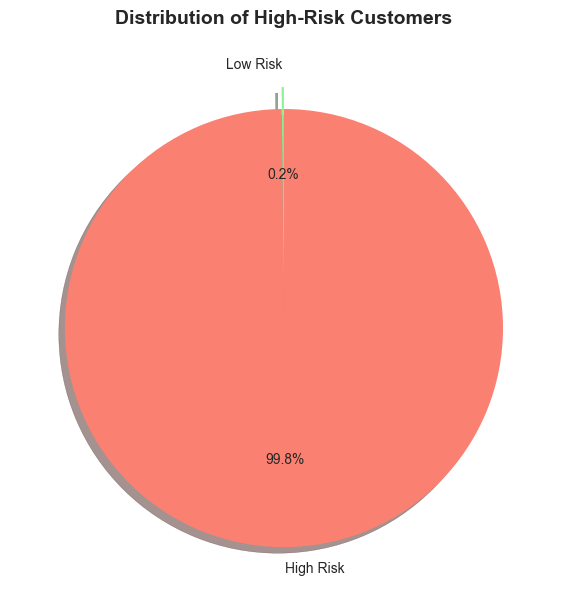

In [10]:
# -------------------------------------------------------------------
# 10. CREATE TARGET VARIABLE
# -------------------------------------------------------------------
print("\n🎯 CREATING TARGET VARIABLE: is_high_risk")
print("=" * 60)

# Create binary target variable
rfm_df['is_high_risk'] = (rfm_df['Cluster'] == high_risk_cluster).astype(int)

print(f"✅ Target variable created: is_high_risk")
print(f"\n📊 Target Distribution:")
target_dist = rfm_df['is_high_risk'].value_counts().sort_index()

risk_summary = pd.DataFrame({
    'Risk_Level': ['Low Risk', 'High Risk'],
    'Count': target_dist.values,
    'Percentage': target_dist.values / len(rfm_df) * 100
})

print(risk_summary.to_string(index=False))

# Visualize target distribution with pie chart
plt.figure(figsize=(10, 6))
colors = ['lightgreen', 'salmon']
explode = (0, 0.1)  # Explode the high-risk slice

plt.pie(target_dist.values, labels=['Low Risk', 'High Risk'], 
        colors=colors, explode=explode, autopct='%1.1f%%',
        startangle=90, shadow=True)
plt.title('Distribution of High-Risk Customers', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{output_dir}target_distribution_pie.png", dpi=300, bbox_inches='tight')
print(f"💾 Target distribution plot saved")
plt.show()


In [11]:
# -------------------------------------------------------------------
# 11. MERGE WITH PROCESSED FEATURES (IF AVAILABLE)
# -------------------------------------------------------------------
print("\n🔗 MERGING TARGET WITH FEATURES")
print("=" * 60)

try:
    # Try to load preprocessed features
    processed_path = "/Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/processed/preprocessed.csv"
    df_processed = pd.read_csv(processed_path)
    print(f"✅ Loaded preprocessed features: {df_processed.shape}")
    
    # Check if we can merge (need CustomerId in both)
    # Since preprocessed data has encoded columns, we need to extract CustomerId
    # Let's check what columns we have
    print(f"Processed data columns (first 10): {df_processed.columns.tolist()[:10]}")
    
    # If processed data doesn't have CustomerId, we'll create a separate target file
    if 'CustomerId' not in df_processed.columns:
        print("⚠️ Processed data doesn't have CustomerId column")
        print("Creating separate target file for manual merging")
        
        # Save target mapping
        target_mapping = rfm_df[['CustomerId', 'is_high_risk', 'Cluster']]
        target_path = f"{output_dir}target_mapping.csv"
        target_mapping.to_csv(target_path, index=False)
        print(f"💾 Target mapping saved to: {target_path}")
        
        # Create dataset with RFM features + target
        rfm_features_target = rfm_df.copy()
        rfm_features_path = f"{output_dir}rfm_features_with_target.csv"
        rfm_features_target.to_csv(rfm_features_path, index=False)
        print(f"💾 RFM features with target saved to: {rfm_features_path}")
    
except FileNotFoundError:
    print("⚠️ Processed features not found")
    print("Creating dataset with RFM features only")
    
    # Save RFM dataset with target
    rfm_features_target = rfm_df.copy()
    rfm_features_path = f"{output_dir}rfm_features_with_target.csv"
    rfm_features_target.to_csv(rfm_features_path, index=False)
    print(f"💾 RFM features with target saved to: {rfm_features_path}")



🔗 MERGING TARGET WITH FEATURES
✅ Loaded preprocessed features: (1913, 55)
Processed data columns (first 10): ['num__Amount_sum', 'num__Amount_mean', 'num__Amount_count', 'num__Amount_std', 'num__Amount_min', 'num__Amount_max', 'num__Amount_median', 'num__Value_mean', 'num__Value_std', 'num__Value_min']
⚠️ Processed data doesn't have CustomerId column
Creating separate target file for manual merging
💾 Target mapping saved to: /Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/processed/target_mapping.csv
💾 RFM features with target saved to: /Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/processed/rfm_features_with_target.csv


In [12]:
# -------------------------------------------------------------------
# 12. SAVE ALL RESULTS
# -------------------------------------------------------------------
print("\n💾 SAVING ALL RESULTS")
print("=" * 60)

# Save RFM data with clusters and target
rfm_output_path = f"{output_dir}rfm_with_clusters_target.csv"
rfm_df.to_csv(rfm_output_path, index=False)
print(f"✅ RFM data with clusters and target saved to: {rfm_output_path}")

# Save cluster analysis
analysis_output_path = f"{output_dir}detailed_cluster_analysis.csv"
analysis_df.to_csv(analysis_output_path, index=False)
print(f"✅ Cluster analysis saved to: {analysis_output_path}")

# Save the KMeans model
import joblib
kmeans_path = f"{output_dir}kmeans_rfm_model.pkl"
joblib.dump(kmeans, kmeans_path)
print(f"✅ KMeans model saved to: {kmeans_path}")

# Save target variable separately
target_only = rfm_df[['CustomerId', 'is_high_risk']]
target_only_path = f"{output_dir}target_variable.csv"
target_only.to_csv(target_only_path, index=False)
print(f"✅ Target variable saved to: {target_only_path}")

# Create summary report
summary_path = f"{output_dir}rfm_analysis_summary.txt"
with open(summary_path, 'w') as f:
    f.write("RFM ANALYSIS SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Total Customers Analyzed: {len(rfm_df):,}\n")
    f.write(f"High-Risk Customers: {target_dist[1]:,} ({target_dist[1]/len(rfm_df)*100:.1f}%)\n\n")
    
    f.write("CLUSTER DISTRIBUTION:\n")
    for cluster, size in cluster_sizes.items():
        percentage = size / len(rfm_df) * 100
        risk_label = "HIGH-RISK" if cluster == high_risk_cluster else f"Cluster {cluster}"
        f.write(f"  {risk_label}: {size:,} customers ({percentage:.1f}%)\n")
    
    f.write("\nHIGH-RISK PROFILE:\n")
    f.write(f"  • Avg Recency: {high_risk_data['Recency'].mean():.1f} days\n")
    f.write(f"  • Avg Frequency: {high_risk_data['Frequency'].mean():.1f} transactions\n")
    f.write(f"  • Avg Monetary: ${high_risk_data['Monetary'].mean():.2f}\n")
    f.write(f"  • Avg Transaction Frequency: {high_risk_data['Transaction_Frequency'].mean():.3f} trans/day\n")

print(f"✅ Summary report saved to: {summary_path}")

# -------------------------------------------------------------------
# 13. FINAL SUMMARY
# -------------------------------------------------------------------
print("\n" + "="*60)
print("🎉 TASK 4 COMPLETE: PROXY TARGET VARIABLE ENGINEERING")
print("="*60)

print(f"\n📋 FINAL SUMMARY:")
print(f"1. ✅ Analyzed {len(rfm_df):,} customers from {len(df_raw):,} transactions")
print(f"2. ✅ Calculated 8 RFM metrics for each customer")
print(f"3. ✅ Applied K-Means clustering (k=3, random_state=42)")
print(f"4. ✅ Identified Cluster {high_risk_cluster} as HIGH-RISK")
print(f"5. ✅ Created target variable 'is_high_risk'")
print(f"6. ✅ {target_dist[1]:,} high-risk customers identified ({target_dist[1]/len(rfm_df)*100:.1f}%)")
print(f"7. ✅ Saved {len(rfm_df.columns)} features for modeling")

print(f"\n🔍 RISK PROFILE SUMMARY:")
print(f"   High-risk customers are characterized by:")
print(f"   • Long inactivity ({high_risk_data['Recency'].mean():.1f} days since last transaction)")
print(f"   • Low engagement ({high_risk_data['Frequency'].mean():.1f} total transactions)")
print(f"   • Low spending (${high_risk_data['Monetary'].mean():.2f} total)")

print(f"\n📁 OUTPUT FILES SAVED TO: {output_dir}")
print(f"   • rfm_with_clusters_target.csv - Complete RFM data with target")
print(f"   • target_variable.csv - Just CustomerId and is_high_risk")
print(f"   • kmeans_rfm_model.pkl - Trained clustering model")
print(f"   • Multiple visualization plots (.png)")

print(f"\n✅ READY FOR MODEL TRAINING!")
print(f"   Use 'is_high_risk' as your target variable for credit risk prediction.")


💾 SAVING ALL RESULTS
✅ RFM data with clusters and target saved to: /Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/processed/rfm_with_clusters_target.csv
✅ Cluster analysis saved to: /Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/processed/detailed_cluster_analysis.csv
✅ KMeans model saved to: /Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/processed/kmeans_rfm_model.pkl
✅ Target variable saved to: /Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/processed/target_variable.csv
✅ Summary report saved to: /Users/elbethelzewdie/Downloads/credit_risk_model/credit-risk-model/data/processed/rfm_analysis_summary.txt

🎉 TASK 4 COMPLETE: PROXY TARGET VARIABLE ENGINEERING

📋 FINAL SUMMARY:
1. ✅ Analyzed 3,742 customers from 95,662 transactions
2. ✅ Calculated 8 RFM metrics for each customer
3. ✅ Applied K-Means clustering (k=3, random_state=42)
4. ✅ Identified Cluster 0 as HIGH-RISK
5. ✅ Created t